In [16]:
from util import constraint
from sympy import *
from IPython.display import display
init_printing()
%matplotlib inline
import copy
import matplotlib.pyplot as plt

import networkx as nx

In [17]:
# Declare symbolic variables for the constraint generators
x1, x2, diff = symbols("x1, x2, diff")

# Define diffRow and diffDiag constraint generators
diffColor = constraint("diffColor", Ne(x1, x2))

In [18]:
class MapColoringCSP:
    """CSP representation of the Map-Coloring problem.
    
    Parameters:
    N: Integer
        The number of cities to be represented in the graph for the problem.
    colors: Integer
        The number of colors available in the domain of every city. Colors are represented by numbers 0,1,2, etc 
        to make a symbol function for colors. 
    neg: Dictionary
        The neighbours of each city are represented in the dictionary that are used to adding constraints to each
        city according to neighbour.
    """
    def __init__(self, N, colors, neg):
        # Declare symbolic variables in the CSP constructor"
        _vars = symbols("city:" + str(N))
        _domain = set(range(colors))
        self.size = N
        self.variables = _vars
        self.domains = {v: set(_domain) for v in _vars}
        self._constraints = {x: set() for x in _vars}

        # Add constraints - for each pair of variables xi and xj that are neighbours, create
        # a diffColor(xi, xj) instance, and add them
        # to the self._constraints dictionary keyed to both xi and xj;
        # (i.e., add them to both self._constraints[xi] and self._constraints[xj])
        z=0
        for i in range(self.size):
            for j in neg[i]:
                xi = self.variables[i]
                xj = self.variables[j]
                diffColor_xi_xj = diffColor.subs({x1: xi, x2: xj})
                self._constraints[xi].add(diffColor_xi_xj)
                self._constraints[xj].add(diffColor_xi_xj)
    
    @property
    def constraints(self):
        """Read-only list of constraints -- cannot be used for evaluation."""
        constraints = set()
        for _cons in self._constraints.values():
            constraints |= _cons
        return list(constraints)
    
    def is_complete(self, assignment):
        """An assignment is complete if it is consistent, and all constraints
        are satisfied. Backtracking search checks consistency of each assignment, 
        so checking for completeness can be done very efficiently by only checking 
        if all the cities are presented on the graph.
        
        Parameters:
        assignment: dict(sympy.Symbol: Integer)
            An assignment of values to variables that have previously been checked
            for consistency with the CSP constraints
        
        Returns:
        True if complete; False otherwise
        """
        return (len(assignment) == self.size)
    
    def is_consistent(self, var, value, assignment):
        """Check consistency of a proposed variable assignment.
        self._constraints[x] returns a set of constraints that involve variable `x`.
        An assignment is consistent unless it causes a constraint to return False 
        (partial assignments are always consistent).
        
        Parameters:
        var: sympy.Symbol
            One of the symbolic variables in the CSP
            
        value: Numeric
            A valid value (i.e., in the domain of) the variable `var` for assignment

        assignment: dict(sympy.Symbol: Integer)
            A dictionary mapping CSP variables to color assignment of each city
            
        Returns:
        True if consistent; False otherwise
        """
        constraints = self._constraints[var]
        assignment_copy = assignment.copy()
        assignment_copy[var] = value
        for constraint in constraints:
            if not(constraint.subs(assignment_copy)):
                return False
        return True
        
    def inference(self, var, value):
        """Perform logical inference based on proposed variable assignment.
        Check arc consistency for var when it's assigned with value. 
        Returns an empty dictionary by default; returning None signals "failure".
        
        Parameters:
        var: sympy.Symbol
            One of the symbolic variables in the CSP
        
        value: Integer
            A valid value (i.e., in the domain of) the variable `var` for assignment
            
        Returns:
        dict(sympy.Symbol: Integer) or None
            A partial set of values mapped to variables in the CSP based on inferred
            constraints from previous mappings, or None to indicate failure
        """        
        inferences = {}
        # Find all unassigned neighbors of var
        neighbors = set([v for v in self.variables if v != var and len(self.domains[v]) != 1])
        for neighbor in neighbors:
            neighbor_domain = list(self.domains[neighbor])
            # Go through all the values of the neighbor's domain, and remove any value that
            # is not consistent with the assignment {var:value}
            for val in neighbor_domain:
                if not self.is_consistent(neighbor, val, {var:value, neighbor:val}):
                    self.domains[neighbor].remove(val)
            # If the domain is empty, no inference is made and return None
            if len(self.domains[neighbor]) == 0:
                return None
            # If the domain has exactly 1 variable, add it to the inferences
            elif len(self.domains[neighbor]) == 1:
                inferences[neighbor] = list(self.domains[neighbor])[0]
        return inferences
    
    def show(self, assn, neg):
        """Display a graph with cities represented as numbers and colors specifies by an assignment
        
        Parameters:
        assn: dict(sympy.Symbol: Integer)
            A dictionary mapping CSP variables to color assignment of each city.
        neg: dict(Integer: Integer)
            A dictionary mapping each city to its neighbours.
            
            
        """
        MG = nx.DiGraph(neg)

        plt.figure(figsize=(8,8))

        nodes = MG.nodes()
        degree = list(assn.values())
        color = [degree[n] for n in nodes]

        nx.draw(MG, nodelist=nodes, node_color=color, node_size=1000,
                with_labels=True, cmap=plt.cm.coolwarm, arrows=False)
        plt.show()

In [19]:
def select(csp, assignment):
    """Choose an unassigned variable in a constraint satisfaction problem """
    # Implement minimum-remaining-values heuristic, i.e. choosing the variable 
    # with the fewest "legal" values
    sorted_variables = sorted(csp.domains.items(), key=lambda x: len(x[1]))
    for var_value_pair in sorted_variables:
        if var_value_pair[0] not in assignment:
            return var_value_pair[0]
    return None

def order_values(var, assignment, csp):
    """Select the order of the values in the domain of a variable for checking during search;
    the default is lexicographically.
    """
    return csp.domains[var]

def backtracking_search(csp):
    """Helper function used to initiate backtracking search """
    return backtrack({}, csp)

def backtrack(assignment, csp):
    """Perform backtracking search for a valid assignment to a CSP
    
    Parameters:
    assignment: dict(sympy.Symbol: Integer)
        A partial set of values mapped to variables in the CSP
        
    csp: CSP
        A problem encoded as a CSP. Interface should include csp.variables, csp.domains,
        csp.inference(), csp.is_consistent(), and csp.is_complete().
    
    Returns:
    dict(sympy.Symbol: Integer) or None
        A partial set of values mapped to variables in the CSP, or None to indicate failure
    """
    if csp.is_complete(assignment):
        return assignment
    var = select(csp, assignment)
    
    assignment_copy = assignment.copy()
    domains_copy = copy.deepcopy(csp.domains)
    inferences = {}
    
    for value in order_values(var, assignment, csp):
        if csp.is_consistent(var, value, assignment):
            assignment[var] = value
            # Update the domain for var with value
            csp.domains[var] = {value}
            inferences = csp.inference(var, value)
            if inferences != None:
                for variable in inferences:
                    if csp.is_consistent(variable, inferences[variable],assignment):
                        assignment[variable] = inferences[variable]
                    else: 
                        inferences = None
                        break
            if inferences != None: # e.g., {}, {col2: 1, col3: 2}, etc.
                result = backtrack(assignment, csp)
                if result:
                    return result
        assignment = assignment_copy.copy()
        csp.domains = copy.deepcopy(domains_copy)
    return None

CSP problems have variables, each variable has a domain, and the problem has a list of constraints.
Showing the variables for the N-Queens CSP:


Showing domain for city0:


And showing the constraints for city0:


Solving Map-Coloring CSP...
Elasped time 0.041497199999980694


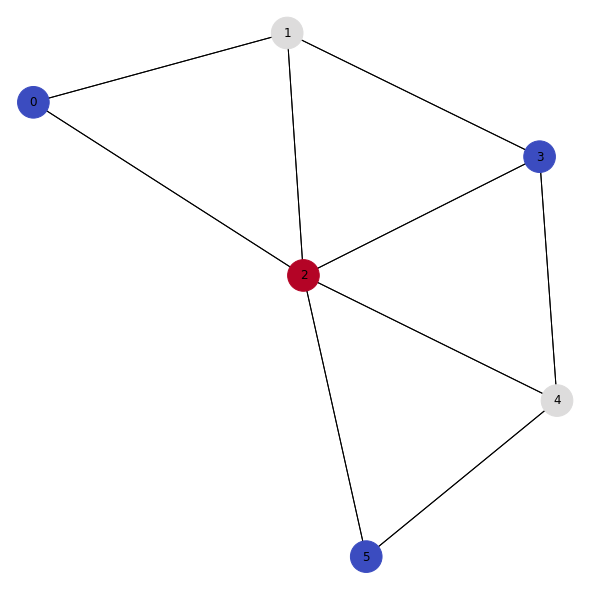

Solution found:
{city0: 0, city1: 1, city2: 2, city3: 0, city4: 1, city5: 0}


In [20]:
import timeit
colors = 3
cities = 6
neg = {
    0: [1,2],
    1: [0,2,3],
    2: [0,1,3,4,5],
    3: [1,2,4],
    4: [2,3,5],
    5: [2,4]
}
csp = MapColoringCSP(cities, colors, neg)
var = csp.variables[0]
print("CSP problems have variables, each variable has a domain, and the problem has a list of constraints.")
print("Showing the variables for the N-Queens CSP:")
display(csp.variables)
print("Showing domain for {}:".format(var))
display(csp.domains[var])
print("And showing the constraints for {}:".format(var))
display(csp._constraints[var])


print("Solving Map-Coloring CSP...")
start_time = timeit.default_timer()
assn = backtracking_search(csp)
elapsed = timeit.default_timer() - start_time
print ("Elasped time", elapsed)
if assn is not None:
    csp.show(assn, neg)
    print("Solution found:\n{!s}".format(assn))
else:
    print("No solution found.")